## 📚 **Huấn Luyện Mô Hình DenseNet-121

## 🎯 **Mục Tiêu Đề Tài**
- Xây dựng và huấn luyện **mô hình DenseNet-121** hoàn chỉnh từ đầu để thực hiện nhiệm vụ **phân loại ảnh** trong tập dữ liệu **CIFAR-10**.  
- Thực hiện toàn bộ quy trình huấn luyện một cách chi tiết, bao gồm:  
  - **Tải dữ liệu CIFAR-10** và **tiền xử lý**.  
  - **Tăng cường dữ liệu** (*Data Augmentation*).  
  - **Phân chia dữ liệu:** Tập **Huấn luyện** và **Kiểm tra**.  
- **Thiết kế mô hình DenseNet-121:**  
  - Không sử dụng các thư viện mô hình dựng sẵn.  
  - Tự xây dựng toàn bộ các lớp như **DenseBlock**, **DenseLayer**, và **Transition Layer**.  
- Đánh giá mô hình qua các chỉ số quan trọng:  
  - **Loss** (*Hàm mất mát*).  
  - **Accuracy** (*Độ chính xác*).  
  - **Thời gian huấn luyện**.  
- **Kiểm thử mô hình**:  
  - Cho phép người dùng tải lên **ảnh tùy chỉnh** để nhận diện đối tượng.  
- **Phân tích và trực quan hóa kết quả:**  
  - Biểu đồ **Loss** và **Accuracy**.  
  - So sánh giữa tập **Train** và **Validation**.

## 🚀 **Yêu Cầu Trước Khi Bắt Đầu**
### Để đảm bảo quá trình huấn luyện nhanh chóng và hiệu quả, bạn cần thực hiện:
- **Kết nối Google Colab với GPU miễn phí.**  
- **Kiểm tra cấu hình GPU**:  
   - Truy cập menu **Runtime (Thời gian chạy)**.  
   - Chọn **Change runtime type (Thay đổi kiểu môi trường)**.  
   - Trong mục **Hardware accelerator (Trình tăng tốc phần cứng)**, chọn: **T4 GPU**.  
   - Nhấn **Save (Lưu)** để hoàn tất.  

## **1. Cài Đặt Thư Viện và Kết Nối Google Drive**

# 📦 Cài Đặt và Kết Nối Google Drive
Mục tiêu:
- Cài đặt các thư viện cần thiết (`pytorch-lightning`, `torchmetrics`)
- Kết nối Google Drive để lưu trữ mô hình và dữ liệu huấn luyện.

### Các bước thực hiện:
1. **Cài đặt thư viện cần thiết:**  
   - `pytorch-lightning`: Framework hỗ trợ huấn luyện mô hình sâu.  
   - `torchmetrics`: Để tính các metric như Accuracy, F1-score, Recall, v.v.  
2. **Kết nối Google Drive:**  
   - Drive sẽ lưu file `.ckpt` của mô hình, file `.json` của lịch sử huấn luyện.  


In [ ]:
# ============================================================
# 1) CÀI ĐẶT VÀ KẾT NỐI GOOGLE DRIVE
# ============================================================
!pip install pytorch-lightning --quiet
!pip install torchmetrics --quiet

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch và các thành phần liên quan
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader

# Thư viện liên quan đến xử lý ảnh và dataset
from torchvision import datasets, transforms
from PIL import Image

# Widgets cho Google Colab (Upload file, hiển thị tương tác)
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output

# Kết nối Drive
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

print("Đã mount Google Drive. base_dir =", base_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Đã mount Google Drive. base_dir = /content/drive/MyDrive


## **2 Khởi Tạo Môi Trường PyTorch Lightning**

# ⚡ Khởi Tạo PyTorch Lightning
Mục tiêu:  
- Thiết lập cấu hình Lightning.  
- Đảm bảo reproducibility (lặp lại kết quả với cùng bộ dữ liệu).  

### Các bước thực hiện:
- **Cấu hình random seed**: Giúp kết quả nhất quán.  
- **Import các thư viện liên quan:** Lightning và Torchmetrics.  

In [ ]:
# ============================================================
# 2) SETUP PYTORCH LIGHTNING
# ============================================================
import pytorch_lightning as pl
pl.seed_everything(42)

import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

INFO:lightning_fabric.utilities.seed:Seed set to 42


 ## **3. Tải Dữ Liệu CIFAR-10 và Xử Lý Dữ Liệu**

 # 📊 Tải Dữ Liệu CIFAR-10 và Tiền Xử Lý
Mục tiêu:  
- Tải tập dữ liệu CIFAR-10 (ảnh 32x32 với 10 lớp).  
- Thực hiện các phép biến đổi dữ liệu (Data Augmentation).  

### Các bước chính:
1. **Tải CIFAR-10**: Tự động tải nếu chưa có.  
2. **Tiền xử lý:**
   - **Train Transform:**  
     - Cắt ngẫu nhiên, lật ngang, xoay ảnh.  
   - **Test Transform:**  
     - Chỉ resize và chuẩn hóa.  
3. **Chia tách dữ liệu:**  
   - Tập huấn luyện và tập kiểm tra.  

In [ ]:
# ============================================================
# 3) HÀM TẢI & TẠO DATALOADER CHO CIFAR-10
# ============================================================
def prepare_cifar10_data(data_dir='/content/drive/MyDrive/cifar_data', batch_size=128):
    """
    - Tải CIFAR-10 và lưu vào data_dir (nếu chưa có).
    - Trả về train_loader, test_loader, train_dataset, test_dataset.
    """
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    print("=> Tải & lưu dữ liệu CIFAR-10 tại:", data_dir)

    # Transform cho train
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    # Transform cho test
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    test_dataset  = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

    # Liệt kê thư mục
    print("Cấu trúc thư mục CIFAR-10:")
    !ls -R {data_dir}

    return train_loader, test_loader, train_dataset, test_dataset

# Gọi hàm và tải dữ liệu
train_loader, val_loader, train_dataset, val_dataset = prepare_cifar10_data(
    data_dir='/content/drive/MyDrive/cifar_data',
    batch_size=128
)

print("Số lượng ảnh train:", len(train_dataset))
print("Số lượng ảnh test:",  len(val_dataset))
class_names = train_dataset.classes
print("Lớp CIFAR-10:", class_names)

=> Tải & lưu dữ liệu CIFAR-10 tại: /content/drive/MyDrive/cifar_data
Files already downloaded and verified
Files already downloaded and verified
Cấu trúc thư mục CIFAR-10:
/content/drive/MyDrive/cifar_data:
cifar-10-batches-py  cifar-10-python.tar.gz

/content/drive/MyDrive/cifar_data/cifar-10-batches-py:
batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
Số lượng ảnh train: 50000
Số lượng ảnh test: 10000
Lớp CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### **3.1. Trực quan hóa tập dữ liệu**

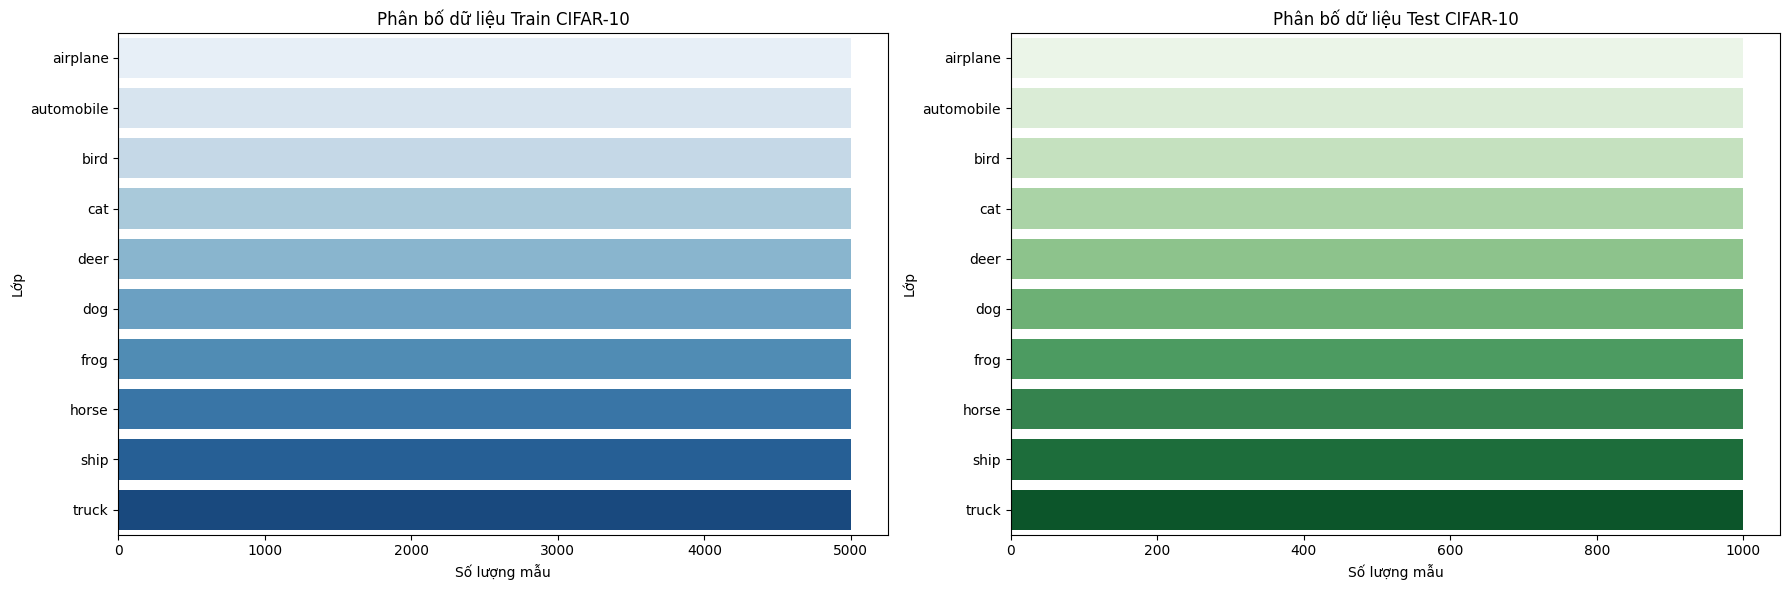

In [ ]:
# ============================================================
# 3.1) TRỰC QUAN HÓA PHÂN BỐ DỮ LIỆU TRAIN & TEST
# ============================================================

# Lấy số lượng mẫu theo lớp
train_counts = [train_dataset.targets.count(i) for i in range(len(train_dataset.classes))]
val_counts = [val_dataset.targets.count(i) for i in range(len(val_dataset.classes))]

# Tạo DataFrame để vẽ biểu đồ
df_train = pd.DataFrame({"Class": train_dataset.classes, "Count": train_counts})
df_val = pd.DataFrame({"Class": val_dataset.classes, "Count": val_counts})

# Tạo một figure với 2 biểu đồ cạnh nhau
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Biểu đồ tập Train (Cập nhật để tránh cảnh báo)
sns.barplot(y="Class", x="Count", data=df_train, hue="Class", palette="Blues", ax=axs[0], legend=False)
axs[0].set_title("Phân bố dữ liệu Train CIFAR-10")
axs[0].set_xlabel("Số lượng mẫu")
axs[0].set_ylabel("Lớp")

# Biểu đồ tập Test (Cập nhật để tránh cảnh báo)
sns.barplot(y="Class", x="Count", data=df_val, hue="Class", palette="Greens", ax=axs[1], legend=False)
axs[1].set_title("Phân bố dữ liệu Test CIFAR-10")
axs[1].set_xlabel("Số lượng mẫu")
axs[1].set_ylabel("Lớp")

# Tinh chỉnh lề và hiển thị
plt.tight_layout()
plt.show()

### 3.2. **Hiển thị ảnh trong lớp**

In [ ]:
# ============================================================
# 3.2) HIỂN THỊ ẢNH THEO LỚP ĐƯỢC NGƯỜI DÙNG CHỌN
# ============================================================

# Hàm đảo ngược Normalize (để hiển thị ảnh gốc)
def denormalize(img, mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)):
    img = img.clone().permute(1, 2, 0).numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)  # Đảm bảo giá trị trong khoảng [0, 1]
    return img

# Dropdown để người dùng chọn lớp và hiển thị ảnh
def display_images_for_class(class_name):
    """
    Hàm hiển thị 4 ảnh ngẫu nhiên từ lớp được người dùng chọn.
    """
    class_idx = train_dataset.classes.index(class_name)
    # Lấy tất cả các chỉ số ảnh thuộc lớp được chọn
    indices = [i for i, label in enumerate(train_dataset.targets) if label == class_idx]

    # Chọn 8 ảnh ngẫu nhiên từ lớp
    selected_indices = random.sample(indices, 4)

    # Hiển thị ảnh
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(selected_indices):
        img, label = train_dataset[idx]
        img = denormalize(img)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Lớp: {train_dataset.classes[label]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Tạo dropdown tương tác cho phép người dùng chọn lớp
interact(display_images_for_class, class_name=Dropdown(options=train_dataset.classes))

interactive(children=(Dropdown(description='class_name', options=('airplane', 'automobile', 'bird', 'cat', 'de…

<function __main__.display_images_for_class(class_name)>

## **4. Xây dựng kiến trúc Densenet121**

## 📦 **Cấu Trúc Tổng Quan:**
- **Input:** Ảnh 32x32 (CIFAR-10).  
- **Growth Rate:** 32  
- **Block Configuration:** (6, 12, 24, 16)  
- **4 DenseBlock + 3 Transition Layer.**  
- **Global Average Pooling → Linear Classifier (10 lớp)**.  

## ✅ **Tóm Tắt:**
- **DenseLayer:** Tạo feature và kết hợp với đầu vào.  
- **DenseBlock:** Kết nối dày đặc các `DenseLayer`.  
- **Transition Layer:** Giảm kích thước và kênh.  
- **DenseNetCIFAR10:** Kết hợp đầy đủ các thành phần để huấn luyện trên CIFAR-10.  


In [ ]:
# ============================================================
# 5) XÂY DỰNG KIẾN TRÚC DENSENET-121
# ============================================================
from collections import OrderedDict

class _DenseLayer(nn.Module):
    """
    Mỗi DenseLayer: BN->ReLU->Conv(1x1) -> BN->ReLU->Conv(3x3), concat
    """
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate,
                               kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate,
                               kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = drop_rate

    def forward(self, x):
        out = self.conv1(self.relu1(self.norm1(x)))
        out = self.conv2(self.relu2(self.norm2(out)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        return torch.cat([x, out], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            layers.append(layer)
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Sequential):
    """
    Transition: BN->ReLU->Conv(1x1) -> AvgPool(2x2)
    """
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.add_module("norm", nn.BatchNorm2d(num_input_features))
        self.add_module("relu", nn.ReLU(inplace=True))
        self.add_module("conv", nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module("pool", nn.AvgPool2d(kernel_size=2, stride=2))

class DenseNetCIFAR10(nn.Module):
    """
    DenseNet-121 cho CIFAR-10 (32x32)
    """
    def __init__(self, growth_rate=32, block_config=(6,12,24,16),
                 num_init_features=64, bn_size=4, drop_rate=0.0, num_classes=10):
        super().__init__()

        # Stem (Khởi đầu mạng)
        self.features = nn.Sequential(OrderedDict([
            ("conv0", nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
            ("norm0", nn.BatchNorm2d(num_init_features)),
            ("relu0", nn.ReLU(inplace=True)),
            ("pool0", nn.MaxPool2d(kernel_size=2, stride=2))
        ]))

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers, num_features, bn_size, growth_rate, drop_rate)
            self.features.add_module(f"denseblock{i+1}", block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_features, num_features // 2)
                self.features.add_module(f"transition{i+1}", trans)
                num_features = num_features // 2

        # BatchNorm Cuối + Classifier
        self.features.add_module("norm_final", nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = F.relu(out, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

## **5. Định Nghĩa LitDenseNet**

## 🎯 **Mục Tiêu:**
- Xây dựng lớp `LitDenseNet` sử dụng **PyTorch Lightning**.  
- Tích hợp toàn bộ quy trình huấn luyện, validation và test trong một class duy nhất.  
- Đảm bảo khả năng huấn luyện dễ theo dõi và mở rộng.  


## 📦 **Cấu Trúc Tổng Quan:**
- **Mô Hình:** Sử dụng `DenseNetCIFAR10` đã xây dựng trước đó.  
- **Các Thành Phần Chính:**
   - `configure_optimizers`: Định nghĩa optimizer và scheduler.  
   - `training_step`: Tính toán loss và accuracy trong huấn luyện.  
   - `validation_step`: Tính toán loss và accuracy trong validation.  
   - `test_step`: Tính toán loss và accuracy trong kiểm tra.  
   - **Logging:** Log loss và accuracy sau mỗi 100 step.

In [ ]:
# ============================================================
# 6) LITDENSENET CHO LIGHTNING >= 2.0 (CHỈ LOG THEO EPOCH)
# ============================================================
class LitDenseNet(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.save_hyperparameters()

        # Khởi tạo mô hình DenseNet CIFAR-10
        self.model = DenseNetCIFAR10(
            growth_rate=32,
            block_config=(6,12,24,16),
            num_init_features=64,
            bn_size=4,
            drop_rate=0.0,
            num_classes=num_classes
        )

        # Metric sử dụng trong training và validation
        self.train_acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc_metric   = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

        # Thiết lập log mỗi 100 step
        self.log_interval = 100
        self.train_step_count = 0

        # Để lưu lịch sử train cho file JSON
        self.history = []

        # Lưu trữ tạm loss & acc cho trung bình cuối epoch
        self.train_losses = []
        self.train_accs   = []

    def forward(self, x):
        return self.model(x)

    # ===========================
    # Cấu hình tối ưu hóa
    # ===========================
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        return [optimizer], [scheduler]

    # ===========================
    # TRAINING
    # ===========================
    def on_train_epoch_start(self):
        self.train_losses = []
        self.train_accs   = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_acc_metric(y_hat, y)

        # Thêm vào danh sách lưu tạm để tính trung bình cuối epoch
        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())

        # Log mỗi 100 step (chỉ hiển thị)
        self.train_step_count += 1
        if self.train_step_count % self.log_interval == 0:
            print(f"Bước [{self.train_step_count}/{len(self.trainer.train_dataloader)}], Loss: {loss.item():.4f}")

        return loss

    def on_train_epoch_end(self):
        # Tính trung bình Loss & Accuracy cuối epoch
        avg_loss = float(np.mean(self.train_losses))
        avg_acc  = float(np.mean(self.train_accs))
        self.log('train_loss_epoch', avg_loss, on_epoch=True, prog_bar=True)
        self.log('train_acc_epoch', avg_acc, on_epoch=True, prog_bar=True)

        # In kết quả cuối epoch
        print(f"Epoch [{self.current_epoch+1}/{self.trainer.max_epochs}], Loss huấn luyện: {avg_loss:.4f}")
        self.train_acc_metric.reset()

    # ===========================
    # VALIDATION
    # ===========================
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_acc_metric(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        current_epoch = self.current_epoch + 1
        train_loss_epoch = float(self.trainer.callback_metrics.get("train_loss_epoch", 0.0))
        val_loss_epoch   = float(self.trainer.callback_metrics.get("val_loss", 0.0))
        val_acc_epoch    = float(self.trainer.callback_metrics.get("val_acc", 0.0))

        # Hiển thị kết quả cuối epoch
        print(f"Loss kiểm tra: {val_loss_epoch:.4f}, Độ chính xác: {val_acc_epoch*100:.2f}%")

        # Ghi vào lịch sử huấn luyện
        self.history.append({
            "epoch": current_epoch,
            "train_loss": train_loss_epoch,
            "val_loss": val_loss_epoch,
            "val_acc": val_acc_epoch
        })

        self.val_acc_metric.reset()

    # ===========================
    # TESTING
    # ===========================
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_acc_metric(y_hat, y)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        return loss

    def on_test_epoch_end(self):
        self.val_acc_metric.reset()

## **6. Huấn Luyện Mô Hình DenseNet-121**

## 🎯 **Mục Tiêu:**
- Huấn luyện mô hình **DenseNet-121** trên tập dữ liệu **CIFAR-10** trong **100 epoch**.  
- **Không sử dụng EarlyStopping**.  
- Chỉ lưu mô hình tốt nhất dựa trên **Validation Accuracy** (`val_acc`).  

## 📦 **Chi Tiết Cấu Hình Huấn Luyện:**
- **Epoch:** 100  
- **Batch Size:** 128  
- **Optimizer:** SGD với Momentum = 0.9  
- **Loss Function:** CrossEntropy  
- **Không sử dụng:** EarlyStopping, CSVLogger.  
- **Log:** Ghi log mỗi **100 step**.  
- **Checkpoint:** Lưu **mô hình tốt nhất** khi `val_acc` đạt cao nhất.  

In [ ]:
# ============================================================
# 7) HUẤN LUYỆN 100 EPOCH, LƯU CHECKPOINT VÀ JSON
# ============================================================

# Callback chỉ lưu checkpoint dựa trên val_acc cao nhất
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath=base_dir,
    filename='best_densenet_cifar10',
    save_top_k=1,
    mode='max'
)

# Tạo Trainer với log mỗi 100 step, KHÔNG có EarlyStopping
trainer = pl.Trainer(
    max_epochs=100,                  # Huấn luyện 100 epoch
    accelerator="auto",
    callbacks=[checkpoint_callback], # Chỉ có checkpoint callback
    log_every_n_steps=100,           # Log mỗi 100 step
    enable_progress_bar=False        # Tắt progress bar, chỉ log text mỗi 100 step
)

# Khởi tạo mô hình
lit_model = LitDenseNet(num_classes=10)

# Huấn luyện mô hình
trainer.fit(lit_model, train_loader, val_loader)

print("=> Quá trình huấn luyện hoàn tất!")
print(f"=> Đường dẫn model tốt nhất: {checkpoint_callback.best_model_path}")

# Lưu lịch sử huấn luyện vào file JSON
history_path = os.path.join(base_dir, 'history_densenet_cifar10.json')
with open(history_path, 'w') as f:
    json.dump(lit_model.history, f, indent=2)

print(f"=> Đã lưu lịch sử huấn luyện vào: {history_path}")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## **7. Kiểm Thử Mô Hình DenseNet-121**

## 🎯 **Mục Tiêu:**
- Kiểm thử mô hình **DenseNet-121** đã huấn luyện.  
- Cho phép người dùng **tải ảnh lên** và mô hình sẽ dự đoán lớp của ảnh đó.  
- Không hiển thị phần trăm dự đoán, chỉ hiển thị **lớp dự đoán cuối cùng**.

## 📦 **Quy Trình Thực Hiện:**
1. **Tải Mô Hình Từ Checkpoint:**  
   - Tải mô hình đã lưu (`.ckpt`).  
2. **Tiền Xử Lý Ảnh:**  
   - Resize ảnh về **32x32** (chuẩn CIFAR-10).  
   - Chuẩn hóa ảnh giống như khi huấn luyện.  
3. **Người Dùng Tải Ảnh Lên:**  
   - Người dùng có thể tải ảnh trực tiếp từ máy tính.  
4. **Dự Đoán:**  
   - Mô hình dự đoán và trả về **nhãn đối tượng**.  
5. **Hiển Thị Kết Quả:**  
   - Hiển thị ảnh kèm **kết quả nhận dạng đối tượng**.  

FileUpload(value={'5_thuyen.jpg': {'metadata': {'name': '5_thuyen.jpg', 'type': 'image/jpeg', 'size': 25472, '…

=> Ảnh đã chọn: 5_thuyen.jpg


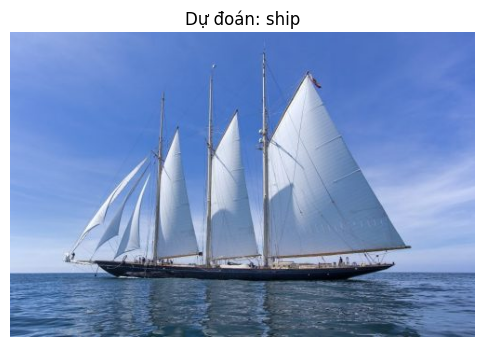

In [ ]:
# ============================================================
# 8) KIỂM THỬ MÔ HÌNH DENSENET-121 TỪ FILE .pt (XÓA KẾT QUẢ CŨ)
# ============================================================

# Đường dẫn model tốt nhất đã lưu từ trước
best_model_path = "/content/drive/MyDrive/best_densenet_cifar10.ckpt"

# Kiểm tra thiết bị và sử dụng GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"=> Đang sử dụng thiết bị: {device}")

# ==========================
# HÀM TẢI MÔ HÌNH TỪ CHECKPOINT
# ==========================
def load_model_from_checkpoint(checkpoint_path):
    model = LitDenseNet.load_from_checkpoint(checkpoint_path)
    model.to(device)  # Đưa model lên đúng thiết bị
    model.eval()
    return model

# Tải mô hình từ checkpoint đã lưu
model = load_model_from_checkpoint(best_model_path)
print(f"=> Đã tải mô hình từ: {best_model_path}")

# ==========================
# HÀM TIỀN XỬ LÝ ẢNH ĐỂ DỰ ĐOÁN
# ==========================
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Đưa lên thiết bị
    return input_tensor

# ==========================
# HÀM DỰ ĐOÁN ẢNH
# ==========================
def predict_image(model, image_tensor, class_names):
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class = torch.max(outputs, 1)
        predicted_label = class_names[predicted_class.item()]
    return predicted_label

# ==========================
# TẠO BUTTON VÀ CẬP NHẬT KẾT QUẢ DỰ ĐOÁN
# ==========================
def on_file_upload(change):
    # Xóa kết quả cũ trước khi hiển thị kết quả mới
    clear_output(wait=True)
    display(upload_button)

    for filename in change['new']:
        # Lưu file tạm
        with open(filename, 'wb') as f:
            f.write(change['new'][filename]['content'])
        print(f"=> Ảnh đã chọn: {filename}")

        # Tiền xử lý và dự đoán ảnh
        image_tensor = preprocess_image(filename)
        predicted_class = predict_image(model, image_tensor, train_dataset.classes)

        # Hiển thị ảnh và kết quả dự đoán mới nhất
        plt.figure(figsize=(6,6))
        img = Image.open(filename)
        plt.imshow(img)
        plt.title(f"Dự đoán: {predicted_class}")
        plt.axis('off')
        plt.show()

# Tạo button chọn file và lắng nghe sự kiện
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
upload_button.observe(on_file_upload, names='value')
display(upload_button)

## **8. Trực Quan Hóa Kết Quả Huấn Luyện**

## 🎯 **Mục Tiêu:**
- Trực quan hóa kết quả huấn luyện của mô hình **DenseNet-121**.  
- So sánh trực tiếp giữa **Train** và **Validation**.  
- Tập trung vào 2 chỉ số chính:  
   - **Loss:** Độ lỗi giảm dần theo quá trình huấn luyện.  
   - **Accuracy:** Độ chính xác tăng dần trong quá trình huấn luyện.  

## 📦 **Dữ Liệu Đầu Vào:**
- **File:** `history_densenet_cifar10.json`.  
- **Dữ Liệu Chứa:**  
   - `train_loss`, `val_loss`.  
   - `train_acc`, `val_acc`.  
   - `epoch`: Số epoch huấn luyện.  

## 📊 **Biểu Đồ Hiển Thị:**
- **Cột 1:** So sánh **Train Accuracy** và **Validation Accuracy**.  
- **Cột 2:** So sánh **Train Loss** và **Validation Loss**.  
- **Đặc Điểm:**
   - Được chia thành **2 biểu đồ** đặt cạnh nhau.  
   - Dễ dàng so sánh trực tiếp giữa tập huấn luyện và kiểm tra.  

🎯 Val Acc cao nhất: 0.9108 tại epoch 81


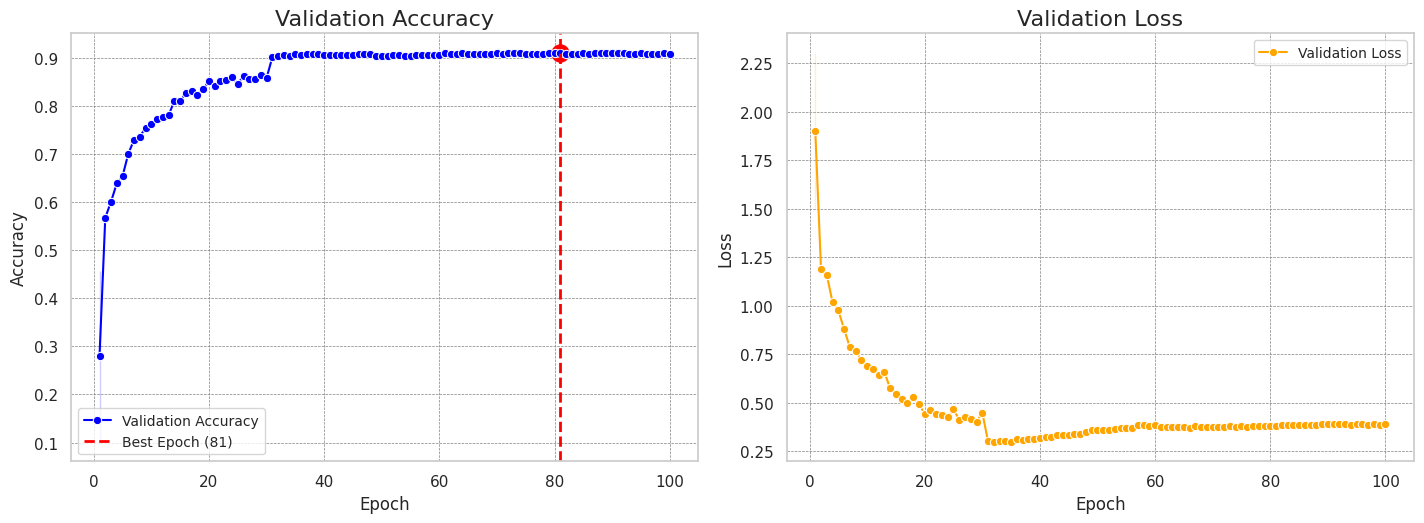

In [ ]:
# ============================================================
# 9) TRỰC QUAN HÓA TỐI ƯU (VAL_ACC & VAL_LOSS) + ĐÁNH DẤU ĐIỂM CAO NHẤT
# ============================================================

# Đường dẫn tới file JSON đã lưu lịch sử huấn luyện
history_path = "/content/drive/MyDrive/history_densenet_cifar10.json"

# Đọc file JSON chứa lịch sử huấn luyện
with open(history_path, 'r') as f:
    history_data = json.load(f)

# Chuyển đổi dữ liệu JSON thành DataFrame để vẽ biểu đồ dễ hơn
df_history = pd.DataFrame(history_data)

# ==========================
# TÌM ĐIỂM VAL_ACC CAO NHẤT
# ==========================
max_val_acc = df_history['val_acc'].max()
best_epoch = df_history[df_history['val_acc'] == max_val_acc]['epoch'].values[0]

print(f"🎯 Val Acc cao nhất: {max_val_acc:.4f} tại epoch {best_epoch}")

# ==========================
# TỐI ƯU TRỰC QUAN HÓA
# ==========================
# Giảm kích thước biểu đồ 10% và thêm khoảng cách giữa các biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(14.4, 5.4))  # Giảm từ (16,6) -> (14.4, 5.4)
plt.subplots_adjust(wspace=0.3)  # Tăng khoảng cách giữa 2 biểu đồ

# Biểu đồ Validation Accuracy (Có Điểm Đánh Dấu)
sns.lineplot(ax=axes[0], x="epoch", y="val_acc", data=df_history, label="Validation Accuracy", marker='o', color='blue')
axes[0].axvline(best_epoch, color='red', linestyle='--', linewidth=2, label=f"Best Epoch ({best_epoch})")
axes[0].scatter(best_epoch, max_val_acc, color='red', s=150)  # Đánh dấu điểm cao nhất
axes[0].set_title("Validation Accuracy", fontsize=16)
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Accuracy", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(color='gray', linestyle='--', linewidth=0.5)

# Biểu đồ Validation Loss
sns.lineplot(ax=axes[1], x="epoch", y="val_loss", data=df_history, label="Validation Loss", marker='o', color='orange')
axes[1].set_title("Validation Loss", fontsize=16)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Loss", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(color='gray', linestyle='--', linewidth=0.5)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()